In [1]:
import tensorflow as tf
import os
from fastai.vision.all import *
from nbdev.showdoc import *
import fastbook
fastbook.setup_book()
import random
from fastai.vision.augment import aug_transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from fastai.data.load import DataLoader
from imblearn.over_sampling import RandomOverSampler
import cv2
import imagej
from torchvision.models import vgg16
import torch.nn as nn
import tensorflow as tf
import os
from fastai.vision.all import *
from nbdev.showdoc import *
import fastbook
import random
from fastai.vision.augment import aug_transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from fastai.data.load import DataLoader
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

2024-06-14 19:10:03.526940: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-14 19:10:03.585071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 19:10:04.570916: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
bac_minus_folder = 'NEGATIVOS'
bac_plus_folder = 'POSITIVOS'

bac_minus_paths = get_image_files(bac_minus_folder)
bac_plus_paths = get_image_files(bac_plus_folder)

bac_minus_labels = [0] * len(bac_minus_paths)
bac_plus_labels = [1] * len(bac_plus_paths)

all_paths = bac_minus_paths + bac_plus_paths
all_paths_list = list(all_paths)


all_labels = bac_minus_labels + bac_plus_labels


In [3]:
df = pd.DataFrame({'image_path': all_paths, 'label': all_labels})


In [4]:
train_val_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

train_df, valid_df = train_test_split(
    train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label']
)

In [5]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    item_tfms=Resize(256),
    batch_tfms=aug_transforms(flip_vert=False, do_flip=False)  # Ejemplo de augmentaciones
)


In [6]:
dls = dblock.dataloaders(train_df, valid_df=valid_df, bs=8)

In [7]:
def get_weights(dls):
    classes = dls.vocab
    train_lbls = L(map(lambda x: classes[x[1]], dls.train_ds))
    label_counter = Counter(train_lbls)
    n_most_common_class = max(label_counter.values())
    print(f'Occurrences of the most common class {n_most_common_class}')
    weights = [n_most_common_class/v for k, v in label_counter.items() if v > 0]
    return weights

In [8]:
learn = cnn_learner(dls, models.vgg16_bn, metrics=[accuracy, Precision(), Recall(), F1Score()])

/data/home/alopezortiz/fastai-master/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [9]:
class_weights = get_weights(dls)

Occurrences of the most common class 2267


In [10]:
weight_tensor = torch.FloatTensor(class_weights)

In [11]:
learn.loss_func = CrossEntropyLossFlat(weight=weight_tensor)

In [12]:
learn.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.021525,0.931334,0.736177,0.196078,0.405405,0.264317,01:43


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.758760,0.650279,0.829384,0.297619,0.337838,0.316456,01:53
1,0.682637,0.578416,0.691943,0.253061,0.837838,0.388715,01:55
2,0.654484,0.531756,0.793049,0.316129,0.662162,0.427948,01:47
3,0.651443,0.465537,0.720379,0.264840,0.783784,0.395904,01:42
4,0.691853,0.575642,0.693523,0.269231,0.945946,0.419162,01:43
5,0.685914,0.439230,0.714060,0.272340,0.864865,0.414239,01:42
6,0.526322,0.468545,0.845182,0.353659,0.391892,0.371795,01:41
7,0.554344,0.483575,0.875197,0.391304,0.121622,0.185567,01:48
8,0.455706,0.408658,0.818325,0.360544,0.716216,0.479638,01:40
9,0.433798,0.470836,0.764613,0.305699,0.797297,0.441948,01:38


In [ ]:
train_losses = [x[0] for x in learn.recorder.values]
valid_losses = [x[1] for x in learn.recorder.values]
accuracies = [x[2] for x in learn.recorder.values]
precision_score = [x[3] for x in learn.recorder.values]
recall_score = [x[4] for x in learn.recorder.values]
f1_score = [x[5] for x in learn.recorder.values]

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'r', label='Train Loss')
plt.plot(epochs, valid_losses, 'b', label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracies, 'b', label='Accuracy')
plt.plot(epochs, precision_score, 'g', label='Precision')
plt.plot(epochs, recall_score, 'm', label='Recall')
plt.plot(epochs, f1_score, 'k', label='F1-score')
plt.title('Accuracy, Precision, Recall and F1-score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

In [ ]:
accuracies_max = max(accuracies)
precision_score_max = max(precision_score)
recall_score_max = max(recall_score)
f1_score_max = max(f1_score)

accuracies_avg = np.mean(accuracies)
precision_score_avg = np.mean(precision_score)
recall_score_avg = np.mean(recall_score)
f1_score_avg = np.mean(f1_score)

print(f'Max accuracy: {accuracies_max}')
print(f'Max precision score: {precision_score_max}')
print(f'Max recall score: {recall_score_max}')
print(f'Max f1 score: {f1_score_max}')

print(f'Average accuracy: {accuracies_avg}')
print(f'Average precision score: {precision_score_avg}')
print(f'Average precision score: {recall_score_avg}')
print(f'Average precision score: {f1_score_avg}')

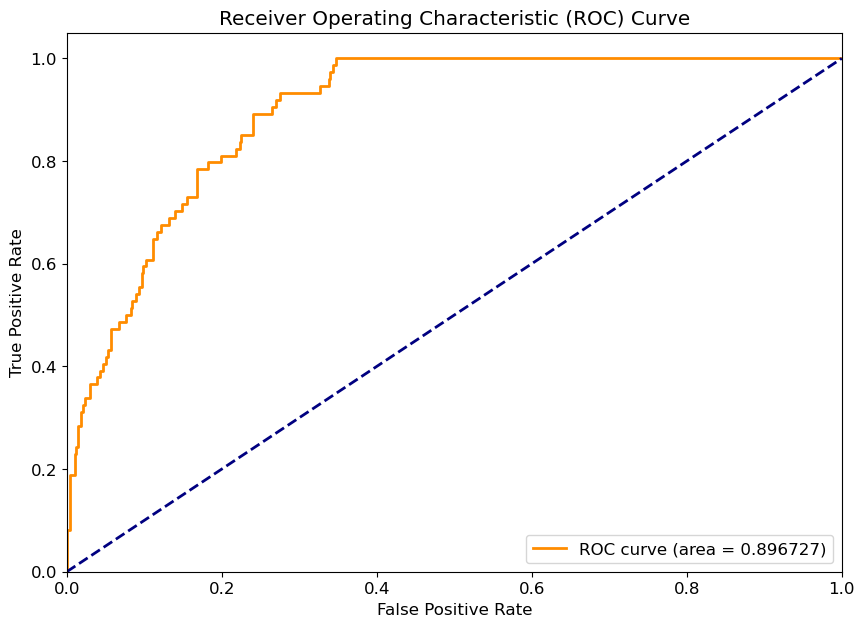

In [24]:
preds, targs = learn.get_preds()
probs = preds[:, 1]
fpr, tpr, _ = roc_curve(targs, probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (area = %f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

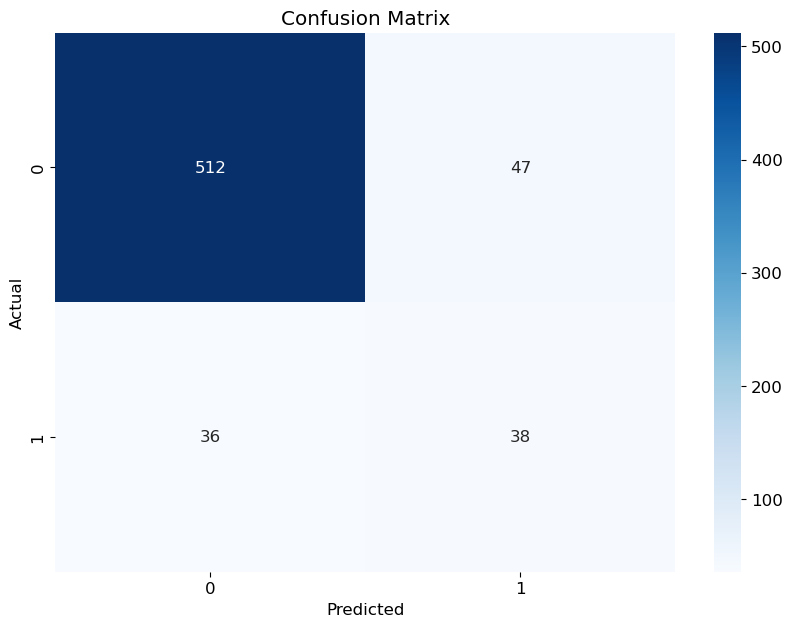

In [25]:
cm = confusion_matrix(targs, preds.argmax(dim=1))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dls.vocab, yticklabels=dls.vocab)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
modelo = learn.export('pesos_vgg.pkl')